<a href="https://colab.research.google.com/github/khalit7/Computer_Vision_Models_Analysis/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=f8e1afc75363abec985a9974f24dc8368ec8a0115a10742002b08a9353413a2f
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [1]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split

import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torchsummary import summary
from sklearn.metrics import accuracy_score
from PIL import Image
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#Dataset

In [2]:
BATCH_SIZE=128

In [3]:
def visualize_data(data_loader,num_examples = BATCH_SIZE ):
  for images,labels in data_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


## MNIST

In [4]:
MNIST_data =   torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
MNIST_data_loader = torch.utils.data.DataLoader(MNIST_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
len(MNIST_data_loader)

469

In [5]:
MNIST_classes = MNIST_data.classes
MNIST_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 1, 28, 28])


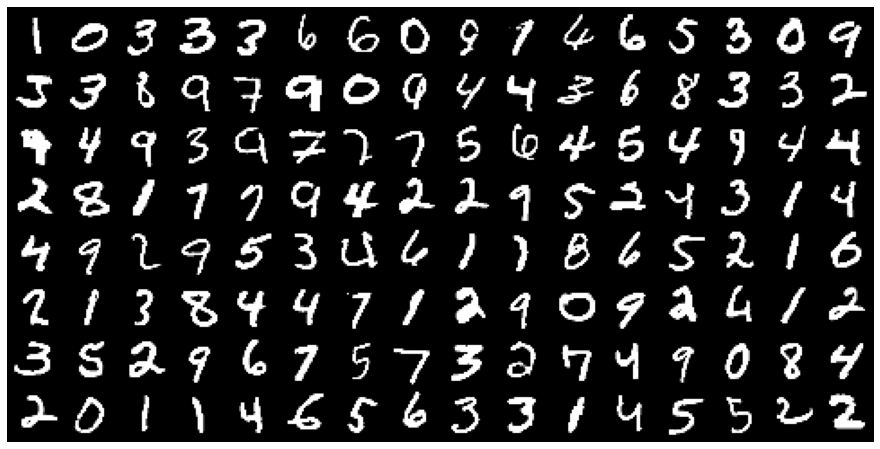

In [8]:
visualize_data(MNIST_data_loader)

## CIFAR

In [9]:
CIFAR_data =   torchvision.datasets.CIFAR10('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
CIFAR_data_loader = torch.utils.data.DataLoader(CIFAR_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
print(len(CIFAR_data_loader))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
391


In [10]:
CIFAR_classes = CIFAR_data.classes
CIFAR_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

images.shape: torch.Size([128, 3, 32, 32])


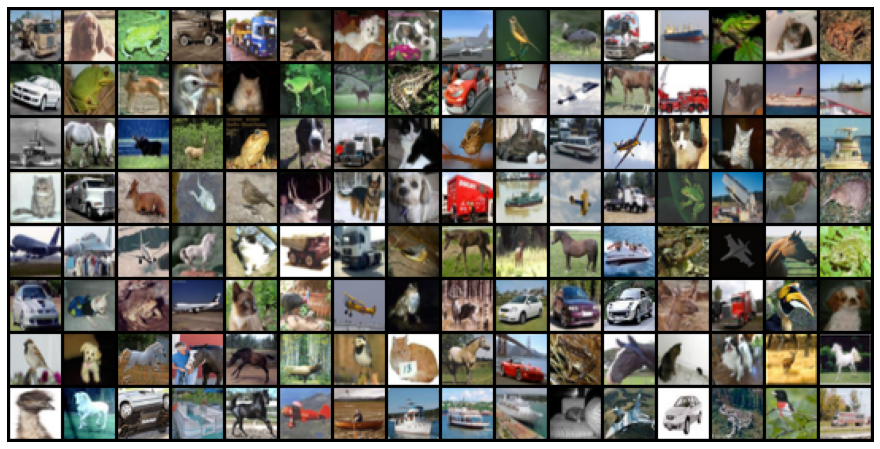

In [11]:
visualize_data(CIFAR_data_loader)

#Models

In [ ]:
# random input to test models if needed 
input = torch.rand(2,3,224,224).to(device)
print(input.dtype)
print(input.shape)

## VGG

## ResNet

In [6]:
resnet = models.resnet34(num_classes=10).to(device)

## GoogleNet

In [ ]:
googlenet = models.googlenet(num_classes= 10).to(device)

## Custom model

#Training and validation functions

In [15]:
obj_func = nn.CrossEntropyLoss()

In [16]:
def training_step(model,optimizer,dataloader):
  avg_loss=0
  correct_preds=0
  for batch_idx,(img,label) in enumerate(dataloader):
    img,label = img.to(device), label.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    #
    output = model(img)
    loss = obj_func(output,label)
    #
    loss.backward()
    optimizer.step()

    # accumulate batch loss
    avg_loss+=loss
    # calculate number of correct predictions
    preds = torch.argmax(output,axis=1)
    correct_preds += torch.sum(preds==label)
  # calculate avg losses
  avg_loss /= len(dataloader.dataset)
  # clculate accuracy
  acc = correct_preds/len(dataloader.dataset)
  return avg_loss.cpu(),acc.cpu()

In [17]:
def evaluate(model,dataloader):
  loss = 0
  correct_preds = 0
  for batch_idx,(img,label) in enumerate(dataloader):
    img,label = img.to(device), label.to(device)
    
    with torch.no_grad():
      output = model(img)
    
    # accumulate bactch loss
    loss += obj_func(output,label)

    # calculate number of correct predictions
    preds = torch.argmax(output,axis=1)
    correct_preds += torch.sum(preds==label)
  
  # calculate average loss
  loss /= len(dataloader.dataset)
  # clculate accuracy
  acc = correct_preds/len(dataloader.dataset)
  return loss.cpu(),acc.cpu()

In [18]:
NUM_EPOCHS = 10
def train(model,optimizer,train_loader,val_loader,num_epochs=NUM_EPOCHS,save_path="./",evaluate_every_epoch = 1):
    training_loss_history = []
    training_acc_history = []
    val_loss_history = []
    val_acc_history = []
    best_acc = 0
    print("Training starting ... ")
    print()
    for epoch in range(num_epochs):
      print("Epoch number {} --------------------------------------------------".format(epoch+1))
      train_loss,train_acc = training_step(model,optimizer,train_loader)
      training_loss_history.append(train_loss)
      training_acc_history.append(train_acc)
      print(" Training Loss = {}, Training Accuracy = {:0.2%} ".format(train_loss,train_acc))
      #
      if ((epoch+1)%evaluate_every_epoch)==0:
        print("performing validation : ")
        val_loss,val_acc = evaluate(model,val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        print(" validation  loss = {}, validation accuracy = {:0.2%} ".format(val_loss,val_acc))
        #TODO: if best val model, save model
        if val_acc > best_acc:
          print("Saving best model so far")
          best_acc = val_acc
          # save model
          torch.save(model.state_dict(), save_path)

    return training_loss_history,training_acc_history,val_loss_history,val_acc_history

# Actual Training

In [11]:
base_path = "/content/drive/MyDrive/computer vision project/"

## ResNet Training

### Prepare data for ResNet

In [12]:
def get_MNIST_resnet(batch_size = BATCH_SIZE):
    mnist = torchvision.datasets.MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader
    
mnist_train,mnist_val = get_MNIST_resnet()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [18]:
def get_CIFAR_resnet(batch_size = BATCH_SIZE):
    cifar = torchvision.datasets.CIFAR10(download=True, train=True, root=".")
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

    train_loader = DataLoader(torchvision.datasets.CIFAR10(download=True, root=".", transform=data_transform, train=True),
                              batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader( torchvision.datasets.CIFAR10(download=True, root=".", transform=data_transform, train=False),
                            batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader
    
cifar_train,cifar_val = get_CIFAR_resnet()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Training on CIFAR

In [48]:
# First we define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Resnet/best_CIFAR"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(resnet,optimizer,cifar_train,cifar_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.01005266048014164, Training Accuracy = 53.15% 
performing validation ----------------------------------------
 validation  loss = 0.00740757817402482, validation accuracy = 67.14% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.006058772560209036, Training Accuracy = 72.75% 
performing validation ----------------------------------------
 validation  loss = 0.005547575186938047, validation accuracy = 75.88% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.004483505617827177, Training Accuracy = 80.02% 
performing validation ----------------------------------------
 validation  loss = 0.004816897213459015, validation accuracy = 79.49% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00350303458981

In [49]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)

[tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0027, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)]
[tensor(0.5315, device='cuda:0'), tensor(0.7275, device='cuda:0'), tensor(0.8002, device='cuda:0'), tensor(0.8442, device='cuda:0'), tensor(0.8779, device='cuda:0'), tensor(0.9078, device='cuda:0'), tensor(0.9312, device='cuda:0'), tensor(0.9468, device='cuda:0'), tensor(0.9608, device='cuda:0'), tensor(0.9672, device='cuda:0')]
[tensor(0.0074, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(0.0048, device='cuda:0')

### Training on MNIST

In [19]:
resnet = models.resnet34(num_classes=10).to(device)


In [20]:
# tweek model slightly to work with MNIST (change the first convolution so it expects a gray scale image)
resnet.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False).to(device)
# First we define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Resnet/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(resnet,optimizer,mnist_train,mnist_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.0008365559624508023, Training Accuracy = 96.74% 
performing validation : 
 validation  loss = 0.0002590863441582769, validation accuracy = 99.02% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.00027115436387248337, Training Accuracy = 98.95% 
performing validation : 
 validation  loss = 0.00017633804236538708, validation accuracy = 99.26% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.00021532687242142856, Training Accuracy = 99.11% 
performing validation : 
 validation  loss = 0.00016875336586963385, validation accuracy = 99.31% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00017521427071187645, Training Accuracy = 99.30% 
performing validation : 
 validation  loss = 0.0001608514867257326

In [21]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)

[tensor(0.0008, grad_fn=<ToCopyBackward0>), tensor(0.0003, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(9.7388e-05, grad_fn=<ToCopyBackward0>), tensor(8.5777e-05, grad_fn=<ToCopyBackward0>)]
[tensor(0.9674), tensor(0.9895), tensor(0.9911), tensor(0.9930), tensor(0.9941), tensor(0.9938), tensor(0.9945), tensor(0.9952), tensor(0.9961), tensor(0.9966)]
[tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(0.0001), tensor(0.0002)]
[tensor(0.9902), tensor(0.9926), tensor(0.9931), tensor(0.9935), tensor(0.9942), tensor(0.9926), tensor(0.9938), tensor(0.9924), tensor(0.9948), tensor(0.9941)]


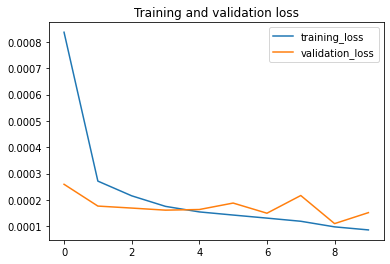

In [28]:
plot_helper("Training and validation loss",training_loss = remove_require_grad(training_loss_history),validation_loss = val_loss_history)

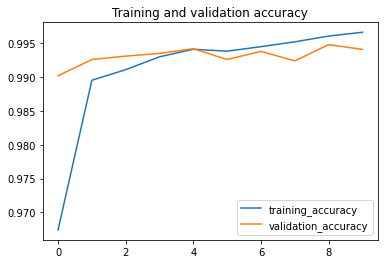

In [24]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

## GoogleNet training

#visualizations

In [22]:
def plot_helper(title,**kwargs):
  for curve_name,history in kwargs.items():
    plt.plot(history,label=curve_name)
  plt.legend()
  plt.title(title)

In [27]:
def remove_require_grad(arr):
  arr = list(map(lambda x:x.detach().numpy(),arr))
  return arr